<a href="https://colab.research.google.com/github/lhb00/basic_pytorch_for_deeplearning/blob/main/basic_pytorch_for_deeplearning_theme_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Theme 8. 비지도 학습
####(1) K-means 알고리즘

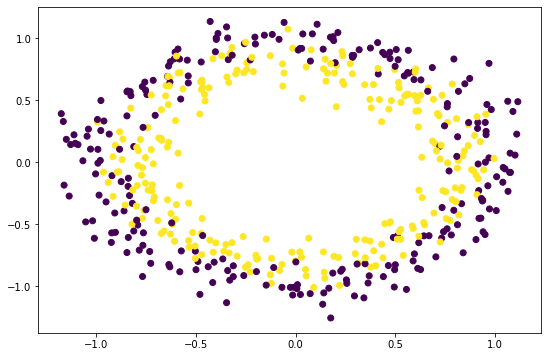

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles # sklearn.datasets에서는 다양한 데이터를 제공. 이 예시에서는 make_circles를 이용.
x, y = make_circles(n_samples=500, noise =0.1) # 500개의 점 생성.
plt.figure(figsize=(9,6))
plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In [ ]:
x = torch.FloatTensor(x)

In [ ]:
def l2distance(a,b): # 거리 함수 정의. L2 거리 함수 사용.
  return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0) # 각 점과 중심과의 거리 계산, 가장 거리가 가까운 점의 인덱스 반환

In [ ]:
def kmeans(x, num_clusters=2, max_iteration = 5): # k-means 알고리즘에서는 클러스터의 수 정하는 것이 필수! 따라서 군집의 수를 모른다면 적절한 숫자 찾아야함.
# 여기서는 기본값을 num_clusters=2로 하였음. max_iteration은 중심이 업데이트되는 횟수를 의미.
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  x = x.to(device)
  centroids = torch.rand(num_clusters, x.size(1)).to(device) # 초기 중심을 랜덤으로 할당. 중심 하나의 벡터 크기는 입력값의 피쳐 개수 x.size(1)와 같아야함.
  for update in range(max_iteration):
    y_assign = []
    for m in range(x.size(0)):
      h = x[m].expand(num_clusters, -1) # 이때 입력값 하나가 각 중심까지의 거리를 구해야하므로, expand를 통해 입력값을 클러스터 개수만큼 복사, 확장.
      assign = l2distance(h, centroids) # 각 입력값마다 모든 중심과의 거리 계산, 가장 가까운 그룹으로 할당.
      y_assign.append(assign.item()) # 할당된 클러스터 정보 제공.

    y_assign = np.array(y_assign)
    if update !=max_iteration-1: # update 횟수 완료될 때까지 완성된 그룹들의 각 평균 계산, 중심 업데이트.
      for i in range(num_clusters):
        idx = np.where(y_assign==i)[0]
        centroids[i] = torch.mean(x[idx], dim=0)
      return y_assign, centroids

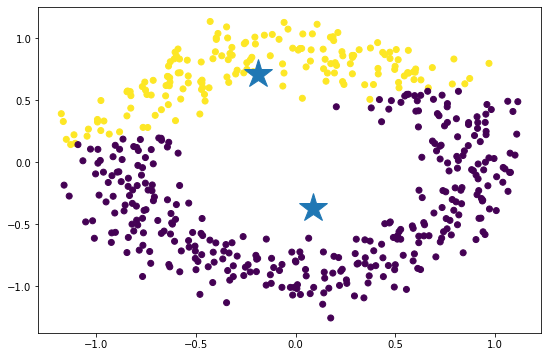

In [ ]:
# 알고리즘 실행 & 그래프 그리기
# K-means 알고리즘은 sklearn에서 제공하는 from sklearn.cluster import KMeans가 가장 많이 사용됨.
# But, 파이토치를 통해 코드 작성 시 추후에 GPU 연산 가능, requires_grad를 사용하여 다른 모델과 조합 시 역전파도 이용 가능. (파이토치를 위한 라이브러리도 존재)
# 이 클러스터링은 방금 전의 클러스터링과 다르게 군집함!
# 따라서 클러스터링은 클러스터링의 종류, 거리 함수 종류, 클러스터의 개수 등의 사항을 잘 따져야함!
y_pred, centroids = kmeans(x,2)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0], x[:,1], c=y_pred)
plt.plot(centroids[:,0], centroids[:,1], '*', markersize=30)
plt.show()

####(3) 오토인코더

#####1. 스택 오토인코더

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataset = torchvision.datasets.MNIST('/content/drive/MyDrive/deeplearning/data', download=True, train=True,
                                     transform=transforms.ToTensor()) # torchvision.datasets.MNIST를 통해 데이터 불러옴. transforms를 이용, 텐서 데이터로 변환.
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

In [ ]:
# 모델 구축
# 기본 오토인코더 모델은 층을 여러개 쌓았기에 스택 오토인코더라고도 불림.
class Autoencoder(nn.Module): # 모델 클래스 정의
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential( # 인코더와
        nn.Linear(784,128), # MNIST 이미지의 크기는 1X28X28임. => nn.Linear에 넣어주기 위해 사진을 일렬로 편 후, 인코더 부분에 크기가 784(28X28)인 벡터 하나가 들어옴.
        nn.ReLU(), # 층을 자유롭게 여러개 쌓아 노드를 10개 까지 줄임. 즉, 잠재 변수의 크기가 10으로 정의됨.
        nn.Linear(128,32),
        nn.ReLU(),
        nn.Linear(32,10),
        nn.ReLU())
    self.decoder = nn.Sequential( # 디코더를 각각 nn.Sequential로 정리
        nn.Linear(10,32), # 크기가 줄어든 잠재 변수 벡터를 디코더에 넣어 다시 크기를 늘려줌.
        nn.ReLU(),
        nn.Linear(32,128),
        nn.ReLU(),
        nn.Linear(128, 28*28), # 마지막은 같은 크기의 이미지가 나와야함. => 28*28로 입력.
        nn.Sigmoid()) # MNIST 이미지의 픽셀값은 0 이상 1이하 => Sigmoid 함수의 성질을 이용해 범위를 정하여 수렴을 빨리 하게 할 수 있다.
    
  def forward(self,x): # forward에서는 encoder, decoder를 차례로 연산할 수 있도록 코드 작성.
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
# 모델, 손실 함수, 최적화 기법 정의
# 우리의 목적은 입력 이미지와 유사한 출력 이미지를 얻는 것. => 입력 이미지 & 출력 이미지의 L2 거리를 계산하는 MSE 손실 함수 사용, 최적화 방법 Adam 사용.
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(51):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs.view(-1, 28*28)) # 현재 오토인코더의 층은 합성곱 층 X, 일렬 노드로 구성된 nn.Linear임. => 이미지를 일렬로 펴서 넣어주기 위해 inputs.view(-1, 28*28))를 입력값으로 이용.
    outputs = outputs.view(-1,1,28,28) # 벡터 형태로 나온 출력값을 다시 정사각형 이미지로 변환하기 위해, outputs.view(-1,1,28,28)를 작성.    
    loss = criterion(inputs, outputs)
    loss.backward()
    optimizer.step()
    running_loss +=loss.item()
  cost = running_loss / len(trainloader)
  print('[%d] loss: %.3f'%(epoch+1, cost))

[1] loss: 0.083
[2] loss: 0.059
[3] loss: 0.051
[4] loss: 0.043
[5] loss: 0.038
[6] loss: 0.036
[7] loss: 0.034
[8] loss: 0.033
[9] loss: 0.031
[10] loss: 0.030
[11] loss: 0.029
[12] loss: 0.029
[13] loss: 0.028
[14] loss: 0.028
[15] loss: 0.027
[16] loss: 0.027
[17] loss: 0.027
[18] loss: 0.027
[19] loss: 0.026
[20] loss: 0.026
[21] loss: 0.026
[22] loss: 0.026
[23] loss: 0.026
[24] loss: 0.026
[25] loss: 0.025
[26] loss: 0.025
[27] loss: 0.025
[28] loss: 0.025
[29] loss: 0.025
[30] loss: 0.025
[31] loss: 0.025
[32] loss: 0.025
[33] loss: 0.025
[34] loss: 0.024
[35] loss: 0.024
[36] loss: 0.024
[37] loss: 0.024
[38] loss: 0.024
[39] loss: 0.024
[40] loss: 0.024
[41] loss: 0.024
[42] loss: 0.024
[43] loss: 0.024
[44] loss: 0.024
[45] loss: 0.024
[46] loss: 0.024
[47] loss: 0.023
[48] loss: 0.023
[49] loss: 0.023
[50] loss: 0.023
[51] loss: 0.023


#####2. 디노이징 오토인코더

In [ ]:
for epoch in range(101):
  running_loss = 0.0
  for data in trainloader:

    inputs = data[0].to(device)
    optimizer.zero_grad()
    dirty_inputs = inputs + torch.normal(0, 0.5, size = inputs.size()).to(device) # 해당 코드는 스택 오토 인코더와 동일, but 입력 이미지에 가우시안 노이즈를 주입한다는 차이점.
    outputs = model(dirty_inputs.view(-1, 28*28)) # 노이즈 텐서의 사이즈=이미지 사이즈여야 하므로 size = inputs.size()를 입력, 평균과 표준편차는 임의로 0, 0.5를 넣음.
    outputs = outputs.view(-1,1,28,28)
    loss = criterion(inputs, outputs)


    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
  cost = running_loss / len(trainloader)
  print('[%d] loss: %.3f' %(epoch + 1, cost))

[1] loss: 0.031
[2] loss: 0.030
[3] loss: 0.029
[4] loss: 0.029
[5] loss: 0.028
[6] loss: 0.028
[7] loss: 0.028
[8] loss: 0.028
[9] loss: 0.028
[10] loss: 0.028
[11] loss: 0.028
[12] loss: 0.027
[13] loss: 0.027
[14] loss: 0.027
[15] loss: 0.027
[16] loss: 0.027
[17] loss: 0.027
[18] loss: 0.027
[19] loss: 0.027
[20] loss: 0.027
[21] loss: 0.027
[22] loss: 0.027
[23] loss: 0.027
[24] loss: 0.027
[25] loss: 0.027
[26] loss: 0.026
[27] loss: 0.026
[28] loss: 0.026
[29] loss: 0.026
[30] loss: 0.026
[31] loss: 0.026
[32] loss: 0.026
[33] loss: 0.026
[34] loss: 0.026
[35] loss: 0.026
[36] loss: 0.026
[37] loss: 0.026
[38] loss: 0.026
[39] loss: 0.026
[40] loss: 0.026
[41] loss: 0.026
[42] loss: 0.026
[43] loss: 0.026
[44] loss: 0.026
[45] loss: 0.026
[46] loss: 0.026
[47] loss: 0.026
[48] loss: 0.026
[49] loss: 0.026
[50] loss: 0.026
[51] loss: 0.026
[52] loss: 0.025
[53] loss: 0.025
[54] loss: 0.025
[55] loss: 0.025
[56] loss: 0.025
[57] loss: 0.025
[58] loss: 0.025
[59] loss: 0.025
[60] l

#####3. 합성곱 오토인코더

In [ ]:
# 피쳐맵을 벡터화
class Flatten(torch.nn.Module):
  def forward(self,x):
    batch_size = x.shape[0] # 인코더를 거친 피쳐맵의 크기 = (배치 사이즈, 채널 수, 이미지 너비, 이미지 높이) => 배치 사이즈 = 현재 이미지의 개수, 벡터가 배치 사이즈 만큼 존재해야함.
    return x.view(batch_size, -1) # 즉, x.view(batch_size, -1)를 이용, 각 피쳐 데이터를 일렬로 변환.

In [ ]:
# 벡터를 사각형 피쳐맵으로 변환
class Deflatten(nn.Module):
  def __init__(self,k):
    super(Deflatten, self).__init__()
    self.k = k

  def forward(self,x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5) # 잠재 변수 h의 크기 = (배치사이즈, 채널 수*이미지 너비*이미지 높이) => 벡터 사이즈 = 채널 수*이미지 너비*이미지 높이, 너비=높이라면 채널 수*이미지 너비**2.
    # 이미지 한 변의 길이 = (벡터 사이즈//채널 수)**.5
    return x.view(s[0], self.k, feature_size, feature_size) # 피쳐맵의 크기를 (배치사이즈, 채널 수, 이미지 너비, 이미지 높이) = (s[0], self.k, feature_size, feature_size)로 반환.

In [ ]:
# 모델 구축
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    k = 16
    self.encoder = nn.Sequential(
        nn.Conv2d(1, k, 3, stride=2), nn.ReLU(), # 합성곱 층 생성
        nn.Conv2d(k, 2*k, 3, stride=2), nn.ReLU(),
        nn.Conv2d(2*k, 4*k, 3, stride = 1), nn.ReLU(),
        Flatten(), nn.Linear(1024, 10), nn.ReLU()) # 합성곱 층으로부터 나온 피쳐맵을 일렬로 폄. 피쳐맵으로 만든 벡터를 은닉층 1개를 거쳐 크기가 10인 잠재 변수로 만듦.
    
    self.decoder = nn.Sequential(
        nn.Linear(10,1024), nn.ReLU(), # 잠재 변수를 은닉층 하나를 통해 다시 크기가 1024인 벡터로 만듦.
        Deflatten(4*k), # 사각형 형태의 피쳐맵으로 변환. nn.Conv2d는 일반적으로 입력 사이즈 < 출력 사이즈임.
        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), nn.ReLU(), # 크기가 작은 입력 값 => 크기가 큰 입력 값으로 만들기 위해 nn.Conv2d 대신 nn.ConvTranspose2d 사용.
        # nn.ConvTranspose2d는 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분, 그 값을 입력 벡터와 곱해 출력 벡터 산출, 그 결과 벡터를 행렬 형태로 변환하는 연산.
        # 사용방법은 nn.Conv2d와 동일(nn.ConvTranspose2d(입력 채널 수, 출력 채널 수, 필터 크기, stride)), 크기는 일반적인 정사각형 이미지와 필터 사용 시 다음 식에 의해 피쳐맵 크기 산출 가능.
        # (출력값의 크기) = (입력값의 크기-1)X(보폭)-2X(패딩)+(필터의 크기)+(출력값 패딩)
        nn.ConvTranspose2d(2*k, k, 3, stride =2), nn.ReLU(),
        nn.ConvTranspose2d(k, 1, 3, stride=2, output_padding=1), nn.Sigmoid()) # output_padding은 크기를 맞춰주기 위해 전치 합성곱 연산 후 패딩을 씌워주는 역할.
    
  def forward(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
# 모델, 손실 함수, 최적화 기법 정의
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 학습하기
# 오토인코더와 학습 과정은 동일. But, 이미지를 그대로 받아 학습하므로 별도의 크기변환 필요 X. => 합성곱 오토인코더는 이미지 처리에서는 기본 신경망을 이용하는 오토인코더보다 성능 좋음.
for epoch in range(51):
  running_loss = 0.0
  for data in trainloader:
    inputs = data[0].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(inputs,outputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  cost = running_loss / len(trainloader)
  if epoch % 10 ==0:
    print('[%d] loss: %.3f' %(epoch +1, cost))

[1] loss: 0.057
[11] loss: 0.022
[21] loss: 0.020
[31] loss: 0.020
[41] loss: 0.019
[51] loss: 0.019


####(4) 생성적 적대 신경망

#####1. Vanilla GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid # 격자 형태의 이미지 생성하는 make_grid 불러오기
import imageio # gif 파일 생성을 위해 imageio 불러오기
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# 티셔츠, 바지, 풀오버, 드레스, 코트, 샌들, 셔츠, 스니커즈, 가방, 앵글부츠로 구성된 FashionMNIST 데이터를 불러옴.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
trainset = FashionMNIST(root='/content/drive/MyDrive/deeplearning/data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 생성자 구축
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.n_features = 128 # 생성자는 잠재 변수로부터 784(28X28) 크기인 벡터 생성. 따라서 잠재 변수의 크기를 임의로 정하고 출력 크기는 이미지를 일렬로 편 크기인 784로 정의.
    self.n_out = 784
    self.linear = nn.Sequential(
        nn.Linear(self.n_features, 256), # 기본 GAN에서는 nn.Linear를 이용, 모델을 구축함. 활성 함수로는 nn.LeakyReLU를 사용.
        nn.LeakyReLU(0.2), # ReLU는 입력값이 0보다 작으면 0으로 값을 바꿔줌 => 음수 구간에서 미분을 할 경우 값은 0. 이때 기울기 사라짐 방지를 위해 음수 구간의 양의 기울기를 주어 값을 계산하는 LeakyReLU(0.2)로 대체.
        nn.Linear(256, 512),
        nn.LeakyReLU(0.2), # 0.2는 음수 구간의 그래프가 y=0.2x라는 의미, 직선의 기울기.
        nn.Linear(512,1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024,self.n_out),
        nn.Tanh())
  def forward(self,x):
    x = self.linear(x) # 정의된 MLP를 거치고 784 크기의 벡터를 크기가 28X28인 흑백 이미지로 변경, 새로운 이미지 생성.
    x = x.view(-1,1,28,28)
    return x

In [ ]:
# 구별자 구축
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.n_in=784 # 이미지를 일렬로 편 크기 입력
    self.n_out = 1 # 출력값은 진위여부를 판단하기 위해 하나의 숫자로 정의.
    self.linear = nn.Sequential(
        nn.Linear(self.n_in, 1024), # nn.Linear을 이용해 구조 정의. 출력값은 0과 1 사이의 값이 출력될 수 있도록 nn.Sigmoid함수를 마지막에 적용.
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256, self.n_out),
        nn.Sigmoid())
  def forward(self,x):
    x = x.view(-1, 784) # 이미지를 벡터 형태로 변경, 신경망에 대입.
    x = self.linear(x)
    return x

In [ ]:
# 모델 정의하기
# 생성자와 구별자를 각각 선언.
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
# 손실 함수 및 최적화 기법 정의
g_optim = optim.Adam(generator.parameters(), lr=2e-4) # 생성자 변수 최적화를 위한 Adam 정의
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4) # 구별자 변수 최적화를 위한 Adam 별도 정의
g_losses = [] # 학습 동안 손실 함수값, 샘플 이미지 저장을 위하여 빈 리스트 생성
d_losses = []
images = []
criterion = nn.BCELoss() # 손실 함수는 이진 크로스 엔트로피 함수 사용

In [ ]:
# 잠재 변수 및 라벨 정의
def noise(n, n_features=128): # 기본적으로 크기가 128인 잠재 변수 n개를 무작위로 생성. 
  data = torch.randn(n, n_features) # 이번 작업은 손실 함수에서 이미지의 진위 여부에 대한 계산. => 실제 이미지의 클래스 사용 X. 진짜 데이터는 라벨 1, 생성자로부터 만들어진 이미지 라벨은 0으로 정의하여 사용.
  return data.to(device)

def label_ones(size): # 이를 위해 1과 0라벨을 만들어주는 함수 정의.
  data = torch.ones(size,1)
  return data.to(device)

def label_zeros(size):
  data = torch.zeros(size,1)
  return data.to(device)

In [ ]:
# 구별자 학습 함수 정의
def train_discriminator(optimizer, real_data, fake_data): # 진짜 이미지, 가짜 이미지, 최적화 함수를 받음.
  n = real_data.size(0) # 각 이미지 진위 라벨 할당을 위해 이미지의 개수 확인.
  optimizer.zero_grad()
  prediction_real = discriminator(real_data) # 진짜 이미지를 판별.
  d_loss = criterion(prediction_real, label_ones(n)) # 이미지 수 만큼 1라벨을 넣어 손실 함수를 계산.
  prediction_fake = discriminator(fake_data) # 가짜 이미지 판별 & 이미지 수 만큼 0라벨을 넣어 손실 함수를 계산.
  g_loss = criterion(prediction_fake, label_zeros(n))
  loss = d_loss + g_loss # 두 손실 함수의 합 => 최종 손실 함수로 사용, 구별자 업데이트.
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
def train_generator(optimizer, fake_data): # 가짜 이미지를 받음.
  n = fake_data.size(0) # 이미지 개수 저장
  optimizer.zero_grad()
  prediction = discriminator(fake_data) # 가짜 이미지를 구별자에 넣어 판별.
  loss = criterion(prediction, label_ones(n)) # 생성자 입장에서는 구별자가 진짜 이미지라고 판단하도록 업데이트 되어야 함. => 0라벨 X, 1라벨을 넣어 손실 함수 계산.
  # 이러한 방식으로 min max 형태의 손실 함수를 직접 구현하지 않고 최적화 수행 가능!
  loss.backward()
  optimizer.step()
  return loss.item()

In [ ]:
# 모델 학습
test_noise = noise(64) # 검증을 위한 무작위 잠재 변수 64개 생성
l = len(trainloader) # 평균 손실값을 구하는데 사용하는 배치 수 저장
for epoch in range(151):
  g_loss = 0.0 # 각 에포크마다 손실값 초기화
  d_loss = 0.0
  for data in trainloader:
    imgs, _ = data # 진짜 이미지를 받고 진짜 이미지의 개수 정의
    n = len(imgs)
    fake_data = generator(noise(n)).detach() # 진짜 이미지의 개수 만큼 가짜 이미지 생성, detach()를 통해 불필요한 requires_grad 비활성화
    real_data = imgs.to(device)
    d_loss +=train_discriminator(d_optim, real_data, fake_data) # 가지고 있는 이미지를 모두 구별자에 넣어 판별, 구별자 업데이트 후 반환한 손실 함수 값 누적
    fake_data = generator(noise(n)) # 생성자 업데이트 후 반환한 손실 함수 값 누적
    g_loss += train_generator(g_optim, fake_data)

  img = generator(test_noise).detach().cpu() # 검증을 위해 고정된 잠재 변수를 넣어 이미지 생성, 변화를 알아보기 위해 격자 형태의 이미지로 만들어 images 리스트에 저장
  img = make_grid(img)
  images.append(img)
  g_losses.append(g_loss/l) # 손실 함수값의 변화 저장
  d_losses.append(d_loss/l)
  if epoch % 10 ==0: # 에포크 10단위 마다 손실값 출력
    print('Epoch {}:g_loss:{:.3f} d_loss:{:.3f}\r'.format(epoch,g_loss/l,d_loss/l))

Epoch 0:g_loss:2.933 d_loss:0.541
Epoch 10:g_loss:1.546 d_loss:0.911
Epoch 20:g_loss:1.402 d_loss:0.952
Epoch 30:g_loss:1.290 d_loss:1.012
Epoch 40:g_loss:1.252 d_loss:1.043
Epoch 50:g_loss:1.242 d_loss:1.061
Epoch 60:g_loss:1.158 d_loss:1.101
Epoch 70:g_loss:1.068 d_loss:1.172
Epoch 80:g_loss:1.128 d_loss:1.147
Epoch 90:g_loss:1.047 d_loss:1.183
Epoch 100:g_loss:1.028 d_loss:1.187


KeyboardInterrupt: ignored

In [ ]:
# 모델 저장
torch.save(discriminator.state_dict(), '/content/drive/MyDrive/deeplearning/models/fmnist_disc.pth')
torch.save(generator.state_dict(), '/content/drive/MyDrive/deeplearning/models/fmnist_gner.pth')

In [ ]:
# 검증 이미지 변화를 gif 파일로 저장
to_image = transforms.ToPILImage() # images 리스트의 원소 하나는 격자 형태로 만들어진 이미지들의 모임 & 크기가 (3,242,242)인 하나의 텐서
# 이때 이미지 저장 형식을 맞추기 위해 TOPILImage()를 이용해 타입과 (242, 242, 3)으로 크기 변환 가능
imgs = [np.array(to_image(i)) for i in images] # 이미지를 넘파이 배열로 변경, gif파일로 만듦.
imageio.mimsave('fashion_items.gif', imgs)

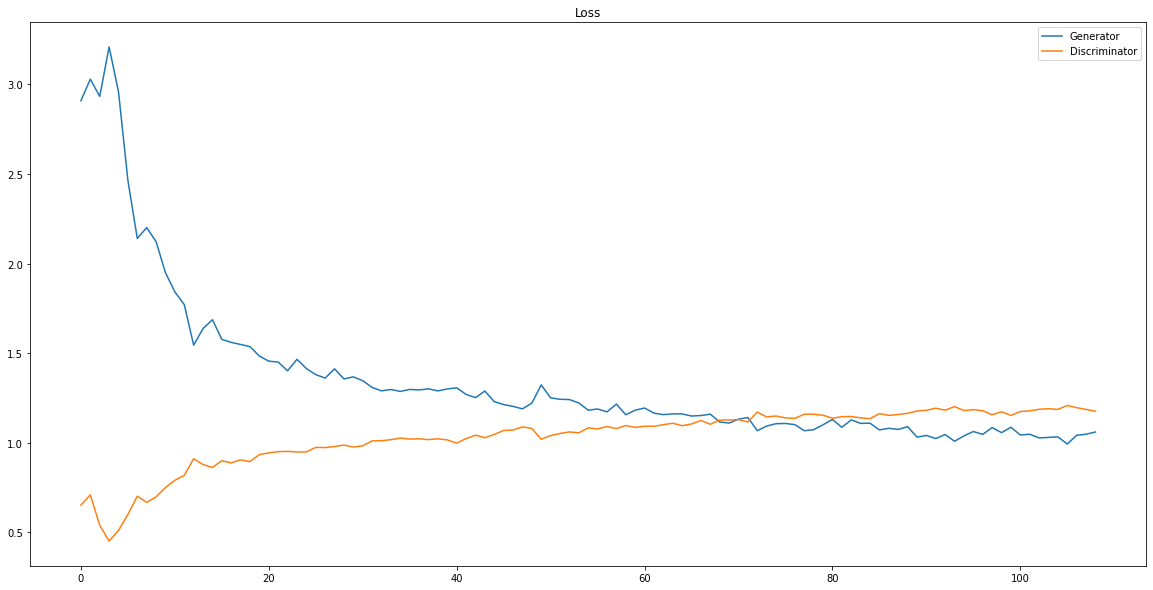

In [ ]:
# 손실 함수 값 그래프 그리기
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

#####2. Deep Convoulutional GAN(DCGAN)

In [ ]:
# DCGAN은 GAN 구조를 합성곱 층으로 구성한 모델.
# 합성곱 신경망은 다층 퍼셉트론보다 이미지 처리에 매우 유리한 네트워크임.
# 실제 다층 퍼셉트론으로 구성된 GAN보다 DCGAN을 통해 조금 더 선명한 이미지 생성 가능!
# 이 예시는 앞의 GAN을 간단하게 합성곱 층으로 변경하여 진행함.
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.n_features = 128 # 크기가 128인 잠재 변수를 가지고 채널이 128개인 1X1 크기 이미지를 입력값으로 받음.
    self.conv = nn.Sequential( # 28X28 이미지 한 장을 얻기 위해 nn.ConvTranspose2d 사용. 
        nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=False), nn.ReLU(True), # nn.ConvTranspose2d는 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분, 그 값을 입력 벡터와 곱해 출력 벡터 산출, 그 결과 벡터를 행렬 형태로 변환하는 연산.
        nn.ConvTranspose2d(256, 128, 3, 2, bias=False), nn.ReLU(True), # 사용 방법 : nn.ConvTranspose2d(입력 채널 수, 출력 채널 수, 필터 크기, stride) 입력.
        nn.ConvTranspose2d(128, 64, 3, 2, bias=False), nn.ReLU(True), # 크기는 일반적인 정사각형 이미지 및 필터 사용 시, 다음 식에 의해 피쳐맵의 크기 산출 가능.
        nn.ConvTranspose2d(64, 1, 2, 2, 1, bias=False), nn.Tanh()) # (출력값의 크기) = (입력값의 크기 - 1) X (보폭) -2 X (패딩) + (필터의 크기) +(출력값 패딩)
  def forward(self,x): # ex. 입력값이 1X1 이미지이고 보폭은 1, 패딩은 0, 필터의 크기는 3X3, 출력값 패딩이 0이라면 출력값의 크기는 3(=0X1-0+3+0이 됨.), 이와 같은 계산 과정을 거치면 생성자의 출력 이미지의 크기가 28X28임을 알 수 있다.
    x = x.view(-1, self.n_features, 1, 1)
    x = self.conv(x)
    return x

In [ ]:
# 구별자 구축
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential( # 진위 여부를 구별하기 위해 합성곱 신경망 적용.
        nn.Conv2d(1, 128, 3, 2, 1, bias=False), # 일반적으로 합성곱 층의 필터는 특징을 추출하는 역할, Dropout 사용 X.
        nn.LeakyReLU(0.2), # But 이번 예시에서는 구별자에 Dropout을 적용, 생성자보다 학습에 불리한 조건을 일부러 가지게 하였음.
        nn.Dropout(0.5),
        nn.Conv2d(128,256, 3, 2, 1, bias=False),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5),
        nn.Conv2d(256, 256, 3, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.5),
        nn.Conv2d(256, 1, 3, 2, bias=False),
        nn.Sigmoid())
  def forward(self,x):
    x = self.conv(x)
    return x.view(-1,1)

####(5) 이미지 스타일 변이

In [65]:
# 이미지 스타일 변이 : 한 장의 스타일 이미지, 한 장의 내용 이미지를 가지고 새로운 스타일의 내용 이미지를 만드는 비지도 학습 방법.
# => 임의의 결과 이미지를 만들고 우리가 원하는 그림이 나올 수 있도록 결과 이미지 업데이트.
# 지금까지 배웠던 방법들이 모델 최적화라면, 스타일 변이는 결과 이미지를 최적화하는 방법 수행 => 모델은 이미 학습된 모델 사용, 최적화 진행 X.
# 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

In [66]:
# 모델 불러오기
# 이미지의 유의미한 특성 추출을 위해 사전 훈련된 모델 중 피쳐 추출 부분(합성곱 층)을 불러옴. 또한 모델에 대해 업데이트 후 피쳐 추출 용도로 사용 => eval() 활성화
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [67]:
# 내용 손실 함수 정의
# 업데이트 하고자 하는 내용 이미지(input)의 피쳐맵 & 원래 내용 이미지(self.target)의 피쳐맵의 손실 계산을 위해 MSE 손실 함수 사용.
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
  def forward(self,input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [68]:
# 스타일 손실 함수 정의
# 스타일 손실 함수는 내용 손실 함수와 다르게 각 피쳐맵의 유사도 비교를 위하여 피쳐맵의 Gram matrix를 구한 결과 값 사용, MSE 손실 함수 계산
def gram_matrix(input): # Gram matrix에 대한 함수 정의
  a, b, c, d = input.size() # 이미지의 크기 저장
  features = input.view(a * b, c * d) # 크기가 (c)X(d)인 이미지를 일렬 벡터로 (배치 크기 a)X(채널 수 b)개 만큼 만듦. 즉, features는 벡터들의 모임인 2차원 텐서.
  G = torch.mm(features, features.t()) # features를 F라 하면, F의 전치 텐서와 F를 행렬 곱을 수행, 즉, 각 벡터들의 내적을 계산, 유사도를 정량적으로 표현 가능.
  return G.div(a * b * c * d) # 마지막으로 전체 크기로 나누어 값 반환.

In [69]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach() # 스타일 이미지(self.target)과

  def forward(self,input):
    G = gram_matrix(input) # 업데이트할 이미지(input)의 각 피쳐맵의 Gram_matrix를 각각 구함.
    self.loss = F.mse_loss(G, self.target) # Gram_matrix를 사용, MSE 계산.
    return input

In [70]:
# 정규화 함수 정의
class Normalization(nn.Module): # 모델의 입력값을 정규화하기 위해 정규화 클래스 정의
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = mean.view(-1,1,1) # 평균과
    self.std = std.view(-1,1,1) # 표준편차 정의
  def forward(self,img):
    return(img - self.mean) / self.std # 들어오는 이미지에 대해 정규화 진행

In [71]:
# 모델 재정의
# 스타일 변환을 위해 모델 중간의 피쳐맵들의 결과들을 활용, 손실 함수 계산 => 어느 부분의 정보를 사용할 것인지 정의해야함
def get_style_model_and_losses(cnn,style_img,content_img):
  content_layers = ['conv_4'] # 내용 손실 함수는 VGG19의 4번째 합성곱 층의 피쳐맵을 사용하여 계산
  style_layers = ['conv_1', 'conv_2', 'conv_3','conv_4', 'conv_5'] # 스타일 손실 함수는 1번째 ~ 5번째 합성곱 층의 피쳐맵 사용 / 스타일 손실 함수는 학습 시 각 층의 손실 함수들의 합으로 정의.
  normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device) # 정규화에 필요한 평균/표준편차 정의
  normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  normalization = Normalization(normalization_mean, normalization_std).to(device) # 정규화 클래스 정의
  content_losses = [] # 각 층의 손실 함수를 별도로 저장하기 위해 리스트 정의
  style_losses = []
  model = nn.Sequential(normalization) # 모델 재정의 시작. 모델의 첫 클래스는 입력값을 정규화하는 normalization으로 시작.
  i = 0
  for layer in cnn.children(): # 원래 모델 CNN의 층을 하나씩 불러옴.
    if isinstance(layer, nn.Conv2d): # 만약 층이 합성곱 층이면
      i+=1 # i를 1씩 더하여
      name = 'conv_{}'.format(i) # 층 이름을 'conv_i'로 하고
    elif isinstance(layer, nn.ReLU): # ReLU, 풀링, 배치 정규화도 똑같이 해줌.
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'maxpool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else: # 이름이 없으면 에러 출력.
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
    model.add_module(name,layer) # 이름을 정한 각 층을 하나씩 model에 추가하여 모델 재구축
    if name in content_layers: # name이 정의된 content_layers에 속할 시 해당 층의 내용 손실 함수에 대해 정의 & 모델에 추가
      target = model(content_img)
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)
    if name in style_layers: # 마찬가지로 name이 정의된 style_layers에 속할 시 스타일 손실 함수에 대해 정의 & 모델에 추가
      target_feature = model(style_img)
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
    for i in range(len(model)-1, -1, -1): # 구성된 model을 역순으로 읽어 최종 손실 함수가 있는 위치 i를 파악.
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break
    model = model[:(i+1)] # 최종 손실 함수가 있는 부분만 모델을 사용 => i번째까지 층을 잘라 그 뒤는 배제한 뒤 모델을 정의.
    return model, style_losses, content_losses

In [72]:
# 결과 이미지 최적화
def run_style_transfer(cnn, content_img, style_img, num_steps=300, style_weight=100000,
                       content_weight=1): # 모델, 내용 이미지, 스타일 이미지, 학습 횟수, 손실 함수의 가중치들을 받음.
  input_img = content_img.clone().detach().requires_grad_(True) # 업데이트하고자 하는 이미지 input_img의 초깃값을 내용 이미지로 정함, 최적화를 위해 requires_grad 활성화
  model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img) # 앞서 정의한 get_style_model_and_losses를 이용, 특정 층에 손실 함수가 들어있는 모델 생성 & 손실 함수와 함께 정의
  optimizer = optim.LBFGS([input_img]) # 최적화 기법은 L-BFGS(Limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm)를 사용, 모델 최적화가 아닌 입력 이미지 최적화를 하는 것이므로 변수에 [input_img]를 넣어줌.
  # LBFGS는 헤시안 행렬(2차 미분)을 계산하는 방법, closure()를 정의하여 1차 미분값들을 저장해야함.
  iteration =[0]
  while iteration[0] <=num_steps:
    def closure(): # 따라서 학습 과정을 closure() 함수 내에서 진행하게 함.
      input_img.data.clamp_(0,1) # 이미지 값을 0 이상 1 이하에서 관리하기 위해 clamp 함수 사용. clamp_(0,1)는 input_img의 값을 0과 1 기준으로 절삭, 0 이상 1 이하의 값만 사용하도록 함.
      # 또한 _는 in-place 방식이라는 의미, 별도의 =없이 원래 input_img를 값을 절삭한 input_img로 만듦.
      optimizer.zero_grad()
      model(input_img)
      style_score = 0 # 지정한 층에서 계산된 스타일 손실 함수와 내용 손실 함수에 각각 가중치를 적용. 
      content_score = 0
      for sl in style_losses:
        style_score +=sl.loss
      for cl in content_losses:
        content_score +=cl.loss
      loss = style_weight*style_score + content_weight*content_score
      loss.backward()
      iteration[0] +=1
      if iteration[0] % 50 ==0:
        print('Iteration {}: Style Loss : {:4f} Content Loss: {:4f}'.format(
            iteration[0], style_score.item(), content_score.item()))
      return style_score + content_score
    optimizer.step(closure) # optimizer.step(closure)을 통해 LBFGS를 작동시킴.
  return input_img.data.clamp_(0,1) # 학습이 완료되면 다시 한 번 값을 정리, 최종 이미지 반환.

In [73]:
# 예제 이미지 불러오기
def image_loader(img_path): # image_loader를 통해 이미지 사이즈는 256X256으로 설정, 4채널 이미지에 대해 3채널로 변경하기 위해 이미지를 불러온 뒤 .convert('RGB') 적용
  loader = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
  image = Image.open(img_path).convert('RGB')
  image = loader(image).unsqueeze(0) # 모델에 사용하기 위해 unsqueeze(0)을 이용, 배치 사이즈 1을 추가, 4차원으로 이미지를 만듦.
  return image.to(device)
style_img = image_loader("/content/drive/MyDrive/deeplearning/data/imgA.jpg") # 내용 이미지, 스타일 이미지를 각각 불러옴.
content_img = image_loader("/content/drive/MyDrive/deeplearning/data/imgB.jpg")

In [74]:
# 이미지 학습하기
output = run_style_transfer(cnn, content_img, style_img)

AttributeError: ignored

In [75]:
# 결과 이미지 보기
def imshow(image, title):
  unloader = transforms.ToPILImage()
  image = unloader(image.squeeze(0).cpu())
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  plt.title(title)
  plt.axis("off")
  plt.show()
imshow(output, title='Output Image')

NameError: ignored

####(6) 깊은 K-means 알고리즘

In [80]:
# 라이브러리 불러오기
import torch # 관련 라이브러리 불러옴.
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linear_sum_assignment as linear_assignment
"""
클러스터링은 그룹의 순서를 고려 X, 데이터 군집화. 
ex. 0, 1, 2를 분류하는 문제라면 클러스터 3개를 사용, 그 결과가 (0,1,2), (0,2,1), (2,0,1) 등 다양한 그룹으로 표현됨.
=> 0,1,2 숫자가 완벽히 나눠졌어도 0이 그룹 0, 1이 그룹 1, 2가 그룹 2가 아닐 수도 있음.
=> 평가 시에는 평가 라벨에 맞춰 그룹을 재배치 해줘야함, 이 때 이분 그래프에서 최소 가중치를 측정하는 linear_assignment 함수 활용.
"""

'\n클러스터링은 그룹의 순서를 고려 X, 데이터 군집화. \nex. 0, 1, 2를 분류하는 문제라면 클러스터 3\n개를 사용, 그 결과가 (0,1,2), (0,2,1), (2,0,1) 등 다양한 그룹으로 표현됨.\n=> 0,1,2 숫자가 완벽히 나눠졌어도 0이 그룹 0, 1이 그룹 1, 2가 그룹 2가 아닐 수도 있음.\n=> 평가 시에는 평가 라벨에 맞춰 그룹을 재배치 해줘야함, 이 때 이분 그래프에서 최소 가중치를 측정하는 linear_assignment 함수 활용.\n'

In [81]:
# 데이터 불러오기
batch_size = 128 # 배치 사이즈 결정
num_clusters = 10 # 적절한 클러스터 수 결정
latent_size = 10 # 잠재변수의 크기, 클러스터 수와 같을 필요 X.
trainset = torchvision.datasets.MNIST('/content/drive/MyDrive/deeplearning/data/', download=True, train=True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST('/content/drive/MyDrive/deeplearning/data/', download=True, train=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
# MNIST 데이터를 불러옴.

In [82]:
# 벡터화, 피쳐맵화 클래스 정의
class Flatten(torch.nn.Module): # 이번 예시에서는 합성곱 오토인코더 사용 => 인코더의 마지막 피쳐맵은 4차원 텐서(배치사이즈, 채널수, 피쳐맵 너비, 높이)가 됨.
# => 잠재 변수를 구하기 위해 인코더 부분에서 나온 피쳐맵을 벡터화.
  def forward(self,x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)

class Deflatten(nn.Module): # 디코더 부분의 계산을 위해 벡터화된 잠재 변수를 다시 4차원 텐서(배치사이즈, 채널수, 피쳐맵너비, 높이)로 변환.
  def __init__(self,k):
    super(Deflatten, self).__init__()
    self.k = k
  def forward(self, x):
    s = x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0], self.k, feature_size,feature_size)

In [83]:
# K-means 알고리즘 정의
class Kmeans(nn.Module): # 클러스터의 중심 centroids를 정의하기 위해 클러스터 개수 num_clusters와 잠재 변수의 크기 latent_size 고정.
# 이는 잠재 변수를 그룹화 하는 것이기 때문에 잠재 변수의 크기=각 중심의 크기 여야 함!
  def __init__(self, num_clusters, latent_size):
    super(Kmeans, self).__init__()
    device = torch.device("cude:0" if torch.cuda.is_available() else "cpu")
    self.num_clusters = num_clusters
    self.centroids = nn.Parameter(torch.rand((self.num_clusters, latent_size)).to(device)) #centroids는 최적화 되어야 할 변수 => nn.Parameter로 정의.

  def argminl2distance(self, a, b): # 잠재 변수의 그룹화를 위해 가장 가까운 중심을 argmin 함수로 찾음. 
  # => torch.sum((a-b)**sum((a-b)**2, dim=1), dim=0)은 각 중심과의 유클리디안 거리
  # torch.argmin(torch.sum((a-b)**2, dim=1),dim=0)은 각 거리들 중 가장 가까운 중심의 인덱스를 추출하는 것. 
    return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0)

  def forward(self,x):
    y_assign = [] # 각 이미지의 클러스터를 저장하기 위한 빈 리스트 y_assign 선언
    for m in range(x.size(0)): # 각 데이터를 그룹화하기 위해 인코더를 통해 나온 잠재 변수를 하나씩 불러옴.
      h = x[m].expand(self.num_clusters, -1) # 계산을 쉽게 하기 위해 하나의 잠재 변수를 클러스터 수 만큼 확장(=복사).
      assign = self.argminl2distance(h, self.centroids) # 앞서 정의한 self.argminl2distance를 통해 각 잠재 변수의 할당 클러스터 산출.
      y_assign.append(assign.item()) # 할당된 클러스터 y_assign에 누적.
    return y_assign, self.centroids[y_assign] # 결과적으로 y_assigndms 0부터 9까지의 값으로 구성되어 있음. => 예측에 사용, 최적화를 위해 각 할당된 클러스터에 대응하는 중심 반환.

In [84]:
class Encoder(nn.Module):
  def __init__(self, latent_size):
    super(Encoder, self).__init__()

    k = 16
    self.encoder = nn.Sequential(
        nn.Conv2d(1, k, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(k, 2*k, 3, stride=2),
        nn.ReLU(),
        nn.Conv2d(2*k, 4*k, 3, stride=1),
        nn.ReLU(),
        Flatten(),
        nn.Linear(1024, latent_size),
        nn.ReLU())
  def forward(self,x):
    return self.encoder(x)    
    s =x.size()
    feature_size = int((s[1]//self.k)**.5)
    return x.view(s[0],self.k,feature_size,feature_size)

class Decoder(nn.Module):
  def __init__(self,latent_size):
    super(Decoder, self).__init__()
    k = 16
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 1024),
        nn.ReLU(),
        Deflatten(4*k),
        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1),
        nn.ReLU(),
        nn.ConvTranspose2d(2*k, k, 3, stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(k,1,3,stride=2, output_padding=1),
        nn.Sigmoid())
  def forward(self,x):
    return self.decoder(x)
# 합성곱 오토인코더에서 정의한 모델을 인코더/디코더를 나누어 정의.

In [85]:
# 클러스터 라벨 재배치 함수 정의
def cluster_acc(y_true, y_pred): # 평가를 위해 실제 라벨, 예측 라벨을 받음.
  y_true = np.array(y_true) # 각 라벨을 넘파이 배열로 변환.
  y_pred = np.array(y_pred) 
  D = max(y_pred.max(), y_true.max()) + 1 # 클러스터가 10개여도 데이터들이 골고루 그룹 0~9로 분배되지 않을 수 있음.
  # ex. 우리가 0,1,2,4,8을 가지고 있을 때 실제 클래스 수보다 적게 클러스터링 됨. => 동일한 클래스 수에서 정확도 측정을 위해 실제 라벨 데이터/예측 라벨 데이터에서 가장 큰 라벨을 기준.
  w = np.zeros((D,D), dtype=np.int64) # 따라서 10X10의 w 행렬을 만들 수 있고 열(실제 라벨), 행(예측 라벨)을 비교하며 할당된 이미지 개수를 넣게 됨. 만약에 예측 라벨이 1, 실제 라벨이 2면 w의 2행 1열 성분에 1을 누적하게됨.
  # => 예측 라벨, 실제 라벨의 관계를 배열 w로 표현.
  for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] +=1
  ind = linear_assignment(w.max() - w) # 배열 w와 linear_assignment를 기준으로 인덱스 재배치
  return sum([w[i,j] for i,j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size # 재배치된 인덱스 정보를 바탕으로 예측 라벨, 실제 라벨이 같은 개수 만큼 더하고 전체 라벨 수를 나누어 정확도 계산.

In [86]:
# 평가 함수 정의
def evaluation(testloader, encoder, kmeans, device):
  predictions = [] # 예측 라벨, 실제 라벨 저장을 위해 빈 리스트 선언
  actual = []

  with torch.no_grad():
    for images, labels in testloader: # 예측 시에는 디코더 부분 필요 X => 인코더와 k-means 알고리즘을 통해 예측값 산출
      inputs = images.to(device)
      labels = labels.to(device)
      latent_var = encoder(inputs)
      y_pred, _ = kmeans(latent_var)

      predictions+=y_pred # 미리 선언한 빈 리스트에 각 라벨 저장
      actual+=labels.cpu().tolist()

    return cluster_acc(actual, predictions) # 누적된 라벨 리스트를 cluster_acc 함수에 넣어 정확도 계산

In [87]:
# 손실 함수 및 최적화 방법 정의
encoder = Encoder(latent_size).to(device) # 모델 선언
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)
criterion1 = torch.nn.MSELoss() # 손실 함수 L = Lrec + lambdaLclu의 두 부분에 대한 손실 함수 정의
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()) + list(kmeans.parameters()), lr=1e-3) # 분리된 모델을 동시에 최적화 하고 싶은 경우 list의 합 이용, 하나로 합쳐줄 수 있음.

In [88]:
# 모델 학습 변수 설정
T1 = 50 # 우리 모델은 lambda에 민감 => 학습 초반에는 작은 lambda=lam/(T1-T2)로 시작, 학습 횟수에 따라 점차 값을 증가하여 lambda=lam 까지 사용하는 방식(annealing)으로 모델 학습.
# lambda에 대한 기준을 정해야함.
T2 = 200
lam = 1e-3
ls = 0.05 # 모델 저장의 기준값 임의로 설정.

In [89]:
# 모델 학습
for ep in range(300): # 학습 횟수는 300
  if (ep>T1) and (ep<T2): # annealing 기법으로 학습 횟수에 따라 lambda 조절.
    alpha = lam*(ep - T1)/(T2 - T1) # 1/100, 2/100, ..., 99/100
  elif ep>=T2:
    alpha = lam
  else:
    alpha = lam/(T2 - T1)
  running_loss = 0.0 # 각 배치마다 손실 함수 값 누적을 위해 running_loss = 0 으로 설정.
  for images, _ in trainloader: # 학습 시 이미지만 사용 => _을 이용, 값을 사용하지 않음.
    inputs = images.to(device) # 오토인코더로부터 나온 가상 이미지와 클러스터의 중심 출력.
    optimizer.zero_grad()
    latent_var = encoder(inputs)
    _, centroids = kmeans(latent_var.detach()) # kmean 부분을 역전파할 때는 잠재 변수 고정, 중심을 변수로 두게 하기 위해 latent_var에 .detach()를 붙여 requires_grad 비활성화.
    outputs = decoder(latent_var)

    l_rec = criterion1(inputs, outputs) # 앞서 정의한 손실 함수 계산 & 최적화 시행.
    l_clt = criterion2(latent_var, centroids)
    loss = l_rec + alpha*l_clt
    loss.backward()
    optimizer.step()
    running_loss +=loss.item()
  avg_loss = running_loss / len(trainloader)
  if ep % 10 ==0: # 학습 횟수 10회 마다 검증 시행.
    testacc = evaluation(testloader, encoder, kmeans, device)
    print('[%d] Train loss: %.4f, Test Accuracy: %.3f' %(ep, avg_loss, testacc))

  if avg_loss <ls: # 훈련 손실 함수를 기준으로 모델들을 저장(절대 평가 내용 반영 불가.)
    ls = avg_loss
    torch.save(encoder.state_dict(), '/content/drive/MyDrive/deeplearning/models/dkm_en.pth')
    torch.save(decoder.state_dict(), '/content/drive/MyDrive/deeplearning/models/dkm_de.pth')
    torch.save(kmeans.state_dict(), '/content/drive/MyDrive/deeplearning/models/dkm_clt.pth')

[0] Train loss: 0.0729, Test Accuracy: 0.114
[10] Train loss: 0.0307, Test Accuracy: 0.118
[20] Train loss: 0.0287, Test Accuracy: 0.285
[30] Train loss: 0.0279, Test Accuracy: 0.366
[40] Train loss: 0.0274, Test Accuracy: 0.482
[50] Train loss: 0.0270, Test Accuracy: 0.531
[60] Train loss: 0.0268, Test Accuracy: 0.560
[70] Train loss: 0.0265, Test Accuracy: 0.618
[80] Train loss: 0.0264, Test Accuracy: 0.630
[90] Train loss: 0.0262, Test Accuracy: 0.646
[100] Train loss: 0.0261, Test Accuracy: 0.672
[110] Train loss: 0.0260, Test Accuracy: 0.687
[120] Train loss: 0.0259, Test Accuracy: 0.691
[130] Train loss: 0.0258, Test Accuracy: 0.691
[140] Train loss: 0.0257, Test Accuracy: 0.699
[150] Train loss: 0.0256, Test Accuracy: 0.703
[160] Train loss: 0.0256, Test Accuracy: 0.704
[170] Train loss: 0.0255, Test Accuracy: 0.702
[180] Train loss: 0.0254, Test Accuracy: 0.699
[190] Train loss: 0.0254, Test Accuracy: 0.702
[200] Train loss: 0.0253, Test Accuracy: 0.706
[210] Train loss: 0.0253

In [91]:
# 최종 모델 평가
encoder.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/dkm_en.pth')) # 저장된 모델을 불러옴.
decoder.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/dkm_de.pth'))
kmeans.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/dkm_clt.pth'))

predictions = [] # 비지도 학습으로 모델을 평가하여 71.04%의 평가 정확도 달성.
actual = []
latent_features = []
with torch.no_grad():
  for images, labels in testloader:
    inputs = images.to(device)
    labels = labels.to(device)
    latent_var = encoder(inputs)
    y_pred, _ = kmeans(latent_var)

    predictions += y_pred
    latent_features+=latent_var.cpu().tolist()
    actual+=labels.cpu().tolist()
print(cluster_acc(actual, predictions))

0.7104
